# Assignment:

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

### Interconnect's services

Interconnect mainly provides two types of services:

1. Internet. The network can be set up via a telephone line (DSL, *digital subscriber line*) or through a fiber optic cable.
    1. Landline communication. The telephone can be connected to several lines simultaneously.

Some other services the company provides include:

- Internet security: antivirus software (*DeviceProtection*) and a malicious website blocker (*OnlineSecurity*)
- A dedicated technical support line (*TechSupport*)
- Cloud file storage and data backup (*OnlineBackup*)
- TV streaming (*StreamingTV*) and a movie directory (*StreamingMovies*)

The clients can choose either a monthly payment or sign a 1- or 2-year contract. They can use various payment methods and receive an electronic invoice after a transaction.

### Data Description

The data consists of files obtained from different sources:

- `contract.csv` — contract information
- `personal.csv` — the client's personal data
- `internet.csv` — information about Internet services
- `phone.csv` — information about telephone services

In each file, the column `customerID` contains a unique code assigned to each client.

The contract information is valid as of February 1, 2020.

# Goal: Predict When a Customer Will Leave

# Open Data

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from joblib import dump
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')


In [3]:
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [4]:
display(contract.head())
display(personal.head())
display(internet.head())
phone.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


# Preprocess Contract Data

In [5]:
contract['BeginDate'].max()

'2020-02-01'

In [6]:
contract[contract['EndDate']!="No"]['EndDate'].max()

'2020-01-01 00:00:00'

In [7]:
# Let's run .info() to see columns types.
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


### Create Column End_Date_Mod

In [8]:
contract['End_Date_Mod'] = contract['EndDate']
contract.loc[contract['End_Date_Mod'] == 'No', 'End_Date_Mod'] = '2020-02-01'

contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,End_Date_Mod
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,2020-02-01
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,2020-02-01
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019-12-01 00:00:00
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,2020-02-01
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019-11-01 00:00:00
...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,2020-02-01
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,2020-02-01
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,2020-02-01
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,2019-11-01 00:00:00


In [9]:
# Lets Convert dates to datetime format
contract['BeginDate']= pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')

contract['End_Date_Mod'] = pd.to_datetime(contract['End_Date_Mod'], errors= 'ignore', format='%Y-%m-%d %H:%M:%S')

display(type(contract.iloc[2,2]))

contract.info()

str

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
End_Date_Mod        7043 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 495.3+ KB


- We create a new column "End_Date_Mod" that displays the current date for people still enrolled.

### Add duration column

In [10]:
contract['Duration'] = contract['End_Date_Mod'] - contract['BeginDate']
contract['Duration'] = contract['Duration'].dt.days
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,End_Date_Mod,Duration
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,2020-02-01,31
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,2020-02-01,1036
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019-12-01,61
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,2020-02-01,1371
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019-11-01,61


In [11]:
contract['TotalCharges'].isna().sum()

0

## Histograms

### Monthly Charges

Text(0.5, 1.0, 'Monthly Charges')

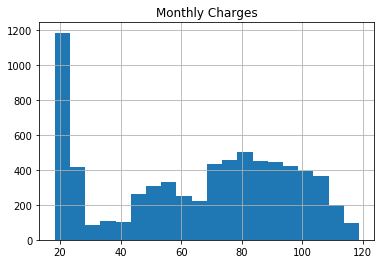

In [12]:
contract['MonthlyCharges'].hist(bins=20)
plt.title('Monthly Charges')



### Total Charges

In [13]:
# Convert column from object to float64

contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

contract['TotalCharges'] = contract['TotalCharges'].fillna(contract['TotalCharges'].mean())

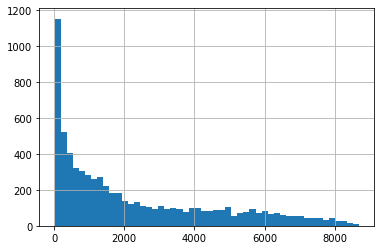

In [14]:
contract['TotalCharges'].hist(bins=50)


# Join Data Using Customer ID

In [15]:
# check to see # of unique customer ids
print('Contract Unique: ', contract['customerID'].nunique())
print('Personal Unique: ', personal['customerID'].nunique())
print('Internet Unique: ', internet['customerID'].nunique())
print('Phone Unique: ', phone['customerID'].nunique())

Contract Unique:  7043
Personal Unique:  7043
Internet Unique:  5517
Phone Unique:  6361


In [16]:
complete_data = contract.merge(internet, on='customerID', how='outer')
complete_data = complete_data.merge(personal, on='customerID', how='outer')
complete_data = complete_data.merge(phone, on='customerID', how='outer')


In [17]:
complete_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
customerID          7043 non-null object
BeginDate           7043 non-null datetime64[ns]
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
End_Date_Mod        7043 non-null datetime64[ns]
Duration            7043 non-null int64
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
MultipleLines   

In [18]:
complete_data['active'] = 1
complete_data.loc[complete_data['EndDate'] == 'No', 'active'] = 0
complete_data

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,End_Date_Mod,Duration,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,active
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,2020-02-01,31,...,No,No,No,No,Female,0,Yes,No,NaN,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,2020-02-01,1036,...,Yes,No,No,No,Male,0,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019-12-01,61,...,No,No,No,No,Male,0,No,No,No,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,2020-02-01,1371,...,Yes,Yes,No,No,Male,0,No,No,NaN,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019-11-01,61,...,No,No,No,No,Female,0,No,No,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,2020-02-01,730,...,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes,0
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,2020-02-01,2191,...,Yes,No,Yes,Yes,Female,0,Yes,Yes,Yes,0
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,2020-02-01,337,...,No,No,No,No,Female,0,Yes,Yes,NaN,0
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60,2019-11-01,123,...,No,No,No,No,Male,1,Yes,No,Yes,1


In [19]:
# convert yes/no to binary and fillna with mean

#columns = ['PaperlessBilling', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
#for n in columns:
#    complete_data.loc[complete_data[n] == 'No', n] = 1
#    complete_data.loc[complete_data[n] == 'Yes', n] = 0
#    complete_data[n].fillna(complete_data[n].mean(), inplace=True)
#    display(complete_data[n].value_counts(dropna=False))

In [20]:
display(complete_data.groupby(by='active').count())
display(complete_data.groupby(by='active').mean())
complete_data.corr()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,End_Date_Mod,Duration,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
active,,,,,,,,,,,,,,,,,,,,,
0,5174,5174,5174,5174,5174,5174,5174,5174,5174,5174,...,3761,3761,3761,3761,3761,5174,5174,5174,5174,4662
1,1869,1869,1869,1869,1869,1869,1869,1869,1869,1869,...,1756,1756,1756,1756,1756,1869,1869,1869,1869,1699


,MonthlyCharges,TotalCharges,Duration,SeniorCitizen
active,,,,
0,61.265124,2554.765772,1144.447236,0.128721
1,74.441332,1531.796094,547.352060,0.254682


,MonthlyCharges,TotalCharges,Duration,SeniorCitizen,active
MonthlyCharges,1.000000,0.650468,0.247754,0.220173,0.193356
TotalCharges,0.650468,1.000000,0.824686,0.102395,-0.199428
Duration,0.247754,0.824686,1.000000,0.016514,-0.352673
SeniorCitizen,0.220173,0.102395,0.016514,1.000000,0.150889
active,0.193356,-0.199428,-0.352673,0.150889,1.000000


In [21]:
complete_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,End_Date_Mod,Duration,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,active
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,2020-02-01,31,...,No,No,No,No,Female,0,Yes,No,NaN,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,2020-02-01,1036,...,Yes,No,No,No,Male,0,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,2019-12-01,61,...,No,No,No,No,Male,0,No,No,No,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,2020-02-01,1371,...,Yes,Yes,No,No,Male,0,No,No,NaN,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,2019-11-01,61,...,No,No,No,No,Female,0,No,No,No,1


# Convert Columns to OHE

In [22]:
columns = ['PaperlessBilling', 'Partner', 'Dependents', 'OnlineSecurity',
           'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
           'StreamingMovies', 'MultipleLines', 'Type', 'PaymentMethod', 
           'gender', 'InternetService']
complete_data_ohe = pd.get_dummies(complete_data, columns=columns, drop_first=True)

complete_data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 26 columns):
customerID                               7043 non-null object
BeginDate                                7043 non-null datetime64[ns]
EndDate                                  7043 non-null object
MonthlyCharges                           7043 non-null float64
TotalCharges                             7043 non-null float64
End_Date_Mod                             7043 non-null datetime64[ns]
Duration                                 7043 non-null int64
SeniorCitizen                            7043 non-null int64
active                                   7043 non-null int64
PaperlessBilling_Yes                     7043 non-null uint8
Partner_Yes                              7043 non-null uint8
Dependents_Yes                           7043 non-null uint8
OnlineSecurity_Yes                       7043 non-null uint8
OnlineBackup_Yes                         7043 non-null uint8
DeviceProtectio

In [23]:
complete_data_ohe = complete_data_ohe.drop(axis=1, columns=['customerID', 'BeginDate', 'EndDate', 'End_Date_Mod'])

In [24]:
complete_data_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
MonthlyCharges                           7043 non-null float64
TotalCharges                             7043 non-null float64
Duration                                 7043 non-null int64
SeniorCitizen                            7043 non-null int64
active                                   7043 non-null int64
PaperlessBilling_Yes                     7043 non-null uint8
Partner_Yes                              7043 non-null uint8
Dependents_Yes                           7043 non-null uint8
OnlineSecurity_Yes                       7043 non-null uint8
OnlineBackup_Yes                         7043 non-null uint8
DeviceProtection_Yes                     7043 non-null uint8
TechSupport_Yes                          7043 non-null uint8
StreamingTV_Yes                          7043 non-null uint8
StreamingMovies_Yes                      7043 non-null uint8
MultipleLines_Yes                  

In [25]:
complete_data_ohe.corr()

,MonthlyCharges,TotalCharges,Duration,SeniorCitizen,active,PaperlessBilling_Yes,Partner_Yes,Dependents_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,...,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,InternetService_Fiber optic
MonthlyCharges,1.000000,0.650468,0.247754,0.220173,0.193356,0.352150,0.096848,-0.113890,0.296594,0.441780,...,0.629603,0.627429,0.490434,0.004904,-0.074681,0.030550,0.271625,-0.377437,-0.014569,0.787066
TotalCharges,0.650468,1.000000,0.824686,0.102395,-0.199428,0.157676,0.318812,0.064535,0.412245,0.509692,...,0.515314,0.519574,0.468689,0.170491,0.357224,0.182581,-0.060412,-0.294125,0.000048,0.360547
Duration,0.247754,0.824686,1.000000,0.016514,-0.352673,0.006059,0.379709,0.159766,0.327203,0.360238,...,0.279657,0.286007,0.331833,0.202650,0.558544,0.233032,-0.208465,-0.233755,0.005111,0.019574
SeniorCitizen,0.220173,0.102395,0.016514,1.000000,0.150889,0.156530,0.016479,-0.211185,-0.038653,0.066572,...,0.105378,0.120176,0.142948,-0.046262,-0.117000,-0.024135,0.171718,-0.153477,-0.001874,0.255338
active,0.193356,-0.199428,-0.352673,0.150889,1.000000,0.191825,-0.150448,-0.164221,-0.171226,-0.082255,...,0.063228,0.061382,0.040102,-0.177820,-0.302253,-0.134302,0.301919,-0.091683,-0.008612,0.308020
PaperlessBilling_Yes,0.352150,0.157676,0.006059,0.156530,0.191825,1.000000,-0.014877,-0.111377,-0.003636,0.126735,...,0.223841,0.211716,0.163530,-0.051391,-0.147889,-0.013589,0.208865,-0.205398,-0.011754,0.326853
Partner_Yes,0.096848,0.318812,0.379709,0.016479,-0.150448,-0.014877,1.000000,0.452676,0.143106,0.141498,...,0.124666,0.117412,0.142057,0.082783,0.248091,0.082029,-0.083852,-0.095125,-0.001808,0.000304
Dependents_Yes,-0.113890,0.064535,0.159766,-0.211185,-0.164221,-0.111377,0.452676,1.000000,0.080972,0.023671,...,-0.016558,-0.039741,-0.024526,0.068368,0.204613,0.060267,-0.150642,0.059071,0.010517,-0.165818
OnlineSecurity_Yes,0.296594,0.412245,0.327203,-0.038653,-0.171226,-0.003636,0.143106,0.080972,1.000000,0.283832,...,0.176207,0.187398,0.098108,0.100162,0.191773,0.115721,-0.112338,-0.080798,-0.017021,-0.030696
OnlineBackup_Yes,0.441780,0.509692,0.360238,0.066572,-0.082255,0.126735,0.141498,0.023671,0.283832,1.000000,...,0.282106,0.274501,0.202237,0.083722,0.111400,0.090785,-0.000408,-0.174164,-0.013773,0.165651


# Check For Class Imbalance

In [26]:
customersTotal = contract.shape[0]
customersWithUs = contract[contract['EndDate'] == 'No'].shape[0]
customersLeftCount = customersTotal - customersWithUs

print('Total customers: ', customersTotal)
print('Customers still with company%', round( ((customersWithUs / customersTotal) * 100),2))
print('Customers left: %', round( ((customersLeftCount / customersTotal) * 100),2))

Total customers:  7043
Customers still with company% 73.46
Customers left: % 26.54


# Split Data

In [27]:
target = complete_data_ohe['active']
features = complete_data_ohe.drop(['active'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=.2, random_state=12345)

scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)

# Create evaluate_model()

In [28]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

# Decision Tree Classifier

In [29]:
model = RandomForestClassifier(class_weight='balanced')

parameters = {'n_estimators': [100, 200], 'max_depth': [5, 25]}

from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(estimator=model, param_grid=parameters, scoring='roc_auc')
clf.fit(features_train, target_train)

predicted_valid = clf.predict(features_valid)


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.77  0.76
F1         0.65  0.65
APS        0.71  0.68
ROC AUC    0.87  0.85


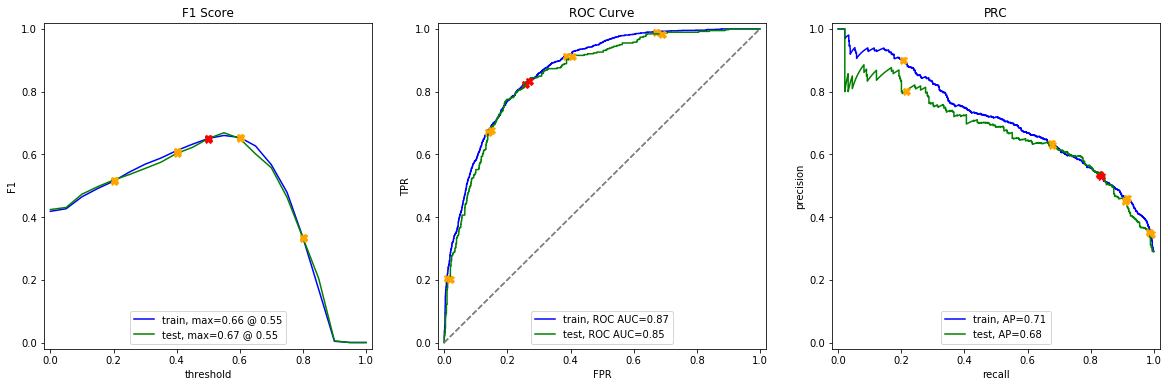

In [30]:
evaluate_model(clf, features_train, target_train, features_valid, target_valid)

# LGBM Classifier

In [31]:
from lightgbm import LGBMClassifier

In [32]:
lightgbm = LGBMClassifier()

lightgbm.fit(features_train, target_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


          train  test
Accuracy   0.92  0.85
F1         0.84  0.67
APS        0.94  0.80
ROC AUC    0.98  0.89


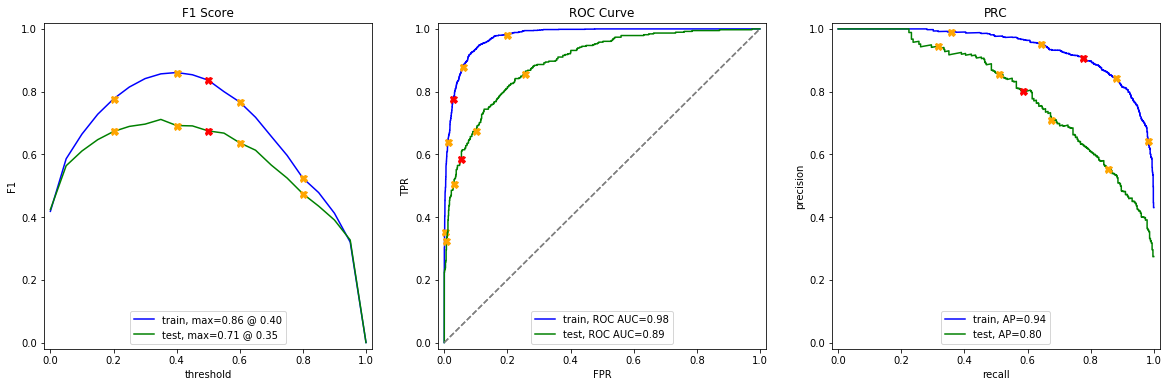

In [33]:
evaluate_model(lightgbm, features_train, target_train, features_valid, target_valid)

# Rough Plan
1. Preprocess the data by analyzing each column. Address data type and missing values.
2. Run OHE on necessary features and target.
3. Balance classes and normalize the data.
4. Extract more features such as duration, year of enrollment, etc.
5. Split data into training set, and test set. Test different models and optimize parameters.
6. Cross validate AUC-ROC.

# Clarifying Questions
1. When running OHE is it improtant to have dummy_na = True?
2. What other EDA would be good to have in this case, I ran a correlation matrix,
is it necessary to have plots with so many features?

# Clarifying Report

1. All the steps were successfuly performed. 
2. Difficulties included not getting the minimum successful scores set out in the task. To increase our score features were added such as customer duration and year of enrollment.
3. A key step to solving the task was optomizing parameters for the DecisionTreeClassifier model. This task was made easier through the use of GridSearchCV; which automates the process of tuning hyperparameters. Another critical step was to maximize the Scores by adjusting the threshold value.
4. LGBM Classifier was the most successful model. Test Scores: Accuracy = 0.85,  F1 = 0.67,  APS = 0.8, & ROC AUC = 0.89.
5. Preprocessing steps taken: normalized the data, applied OHE to categorical columns, converted dates to datetime format in order to calculate customer duration, made a binary target column, changed end dates with output "no" to the latest date from the dataset.
6. Features Used:
       'MonthlyCharges', 'TotalCharges', 'Duration', 'SeniorCitizen',
       'PaperlessBilling_Yes', 'Partner_Yes', 'Dependents_Yes',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes',
       'MultipleLines_Yes', 'Type_One year', 'Type_Two year',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'gender_Male', 'InternetService_Fiber optic'